In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psfs

In [2]:
def find_centroid_com(image):
    x = np.arange(image.shape[1])
    y = np.arange(image.shape[0])
    X, Y = np.meshgrid(x, y)
    x_com = np.sum(X * image) / np.sum(image)
    y_com = np.sum(Y * image) / np.sum(image)
    # Define the center of the image as the origin
    x_com -= image.shape[1] / 2 - 0.5
    y_com -= image.shape[0] / 2 - 0.5
    return np.array([x_com, y_com])

def shift_values(arr, del_x, del_y):
    '''Shift values in an array by a specified discrete displacement.
    
    Parameters
    ----------
    arr : array-like
        The intensity grid.
    del_x : int
        The x displacement, in subpixels.
    del_y : int
        The y displacement, in subpixels.
        
    Returns
    -------
    new_arr : array-like
        The shifted array.
    '''
    n, m = arr.shape
    new_arr = np.zeros_like(arr)
    # print(abs(del_x) > m, abs(del_y) > n)
    new_arr[max(del_y, 0):m+min(del_y, 0), max(del_x, 0):n+min(del_x, 0)] = \
        arr[-min(del_y, 0):m-max(del_y, 0), -min(del_x, 0):n-max(del_x, 0)]
    return new_arr

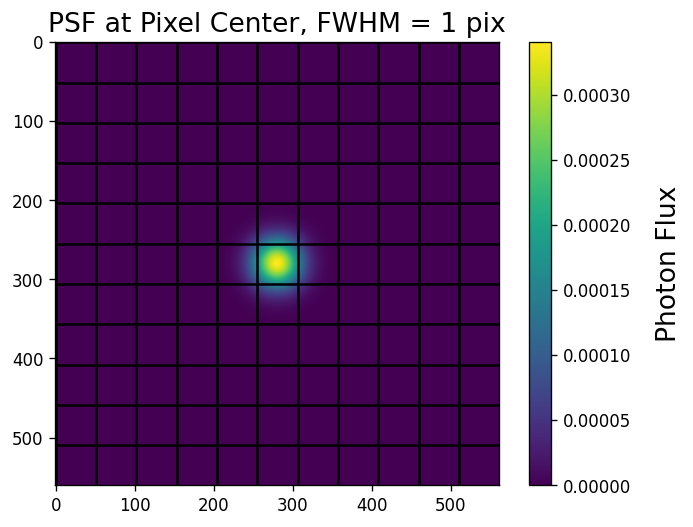

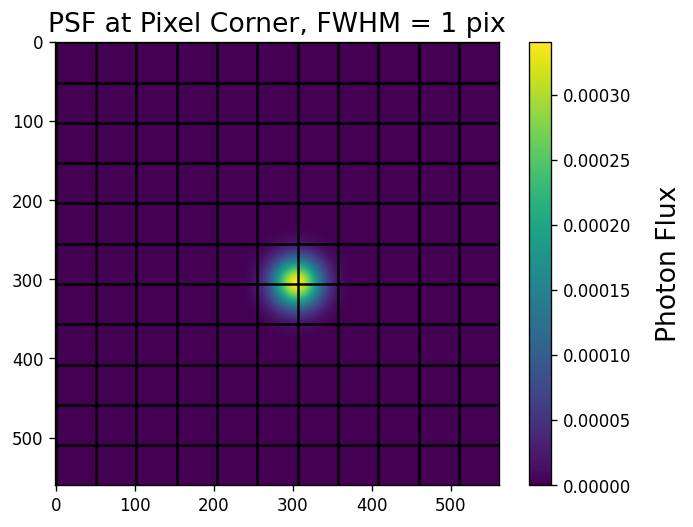

In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams.update({'axes.titlesize': 16})
img_size = 11
resolution = 51
psf_sigma = 1.0 / 2.355 # microns
pix_size = 1 # microns
psf_center = np.array([0, 0])
true_psf = psfs.gaussian_psf(img_size, resolution, pix_size, psf_center, [[psf_sigma ** 2, 0],[0, psf_sigma ** 2]])
# lam_fnum_angstroms = psf_sigma / 0.42 * 1e4
# true_psf = psfs.airy_disk(img_size, resolution, pix_size, [0,0], lam=lam_fnum_angstroms, fnum=1.0)
# truncate the PSF so that we don't misinterpret wings falling off the edge of the image as
# a difference due to the IPRF
true_psf[:resolution+1, :] = 0
true_psf[-resolution-1:, :] = 0
true_psf[:, :resolution+1] = 0
true_psf[:, -resolution-1:] = 0
# plt.imshow(true_psf, norm='log')
plt.imshow(true_psf)
cbar = plt.colorbar(label='Photon Flux')
cbar.ax.yaxis.label.set_fontsize(16)
cbar.ax.yaxis.labelpad = 15
# Superimpose a grid showing pixels
for i in range(img_size):
    plt.axhline(i * resolution, color='black')
    plt.axvline(i * resolution, color='black')
plt.title('PSF at Pixel Center, FWHM = 1 pix')
plt.show()

shifted_true_psf = shift_values(true_psf, resolution // 2, resolution // 2)
plt.imshow(shifted_true_psf)
cbar = plt.colorbar(label='Photon Flux')
cbar.ax.yaxis.label.set_fontsize(16)
cbar.ax.yaxis.labelpad = 15
# Superimpose a grid showing pixels
for i in range(img_size):
    plt.axhline(i * resolution, color='black')
    plt.axvline(i * resolution, color='black')
plt.title('PSF at Pixel Corner, FWHM = 1 pix')
plt.show()
# observed_perfect_psf = true_psf.reshape((img_size, resolution, img_size,
#                                 resolution)).sum(axis=(1, 3))
# plt.imshow(observed_perfect_psf)
# plt.title('Observed PSF with Perfect Pixels')
# cbar = plt.colorbar(label='Photoelectron Flux')
# cbar.ax.yaxis.label.set_fontsize(16)
# cbar.ax.yaxis.labelpad = 15
# for i in range(img_size):
#     plt.axhline(i + 0.5, color='black')
#     plt.axvline(i + 0.5, color='black')
# plt.show()

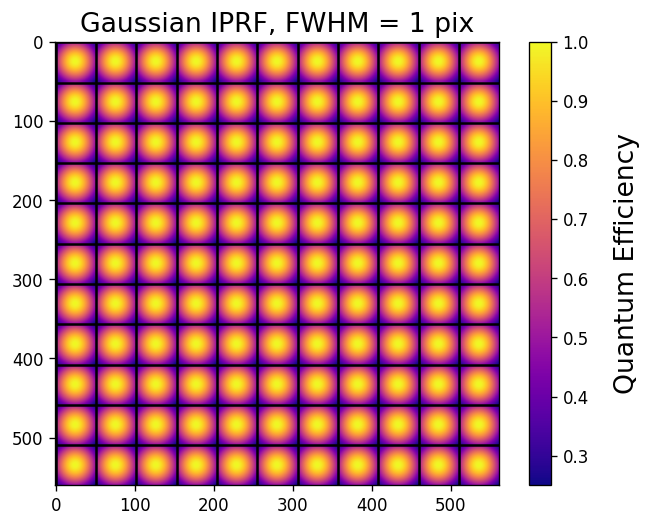

0.6461453061302141


In [4]:
intrapix_sigma = 1.0 / 2.355 # microns
max_qe = 1.0 # Maximum QE of any point in a pixel
response_max_pos = np.array([0.0, 0.0]) * pix_size
intrapix_single = psfs.gaussian_psf(1, resolution, pix_size, response_max_pos,
                                    [[intrapix_sigma ** 2, 0],[0, intrapix_sigma ** 2]])
intrapix_single = (intrapix_single / np.max(intrapix_single)) * max_qe
avg_qe = np.mean(intrapix_single)
intrapix_grid = np.tile(intrapix_single, (img_size, img_size))
# Use a different color map to distinguish from PSF
plt.imshow(intrapix_grid, cmap='plasma')
cbar = plt.colorbar(label='Quantum Efficiency')
cbar.ax.yaxis.label.set_fontsize(16)
cbar.ax.yaxis.labelpad = 15
plt.title('Gaussian IPRF, FWHM = 1 pix')
# Add grid lines
for i in range(img_size):
    plt.axhline(i * resolution, color='black')
    plt.axvline(i * resolution, color='black')
plt.show()
print(avg_qe)

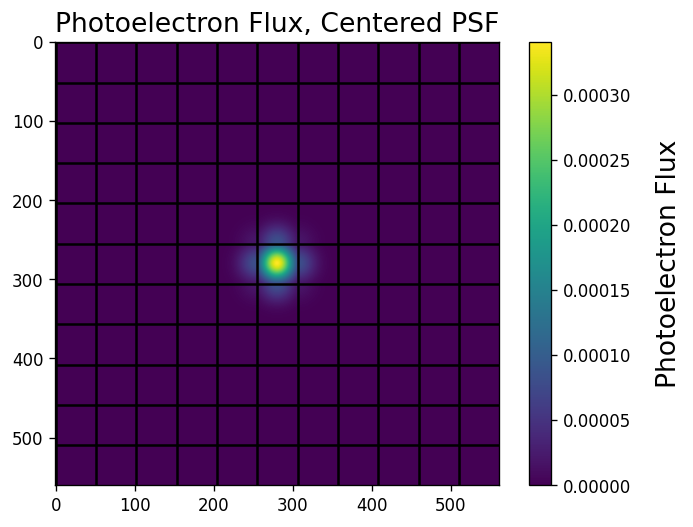

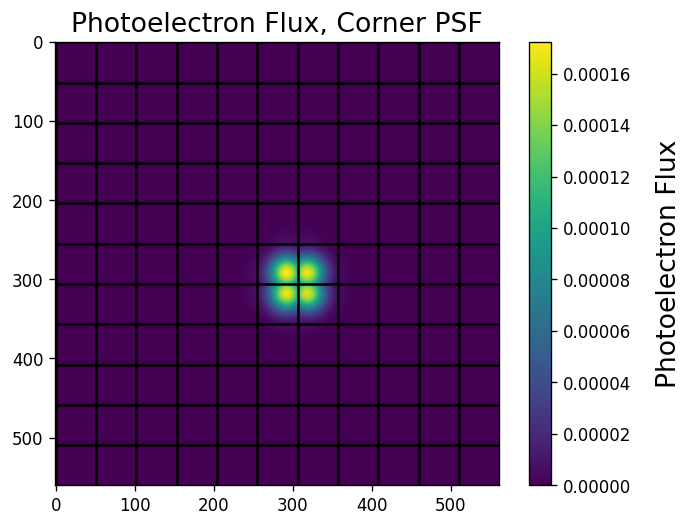

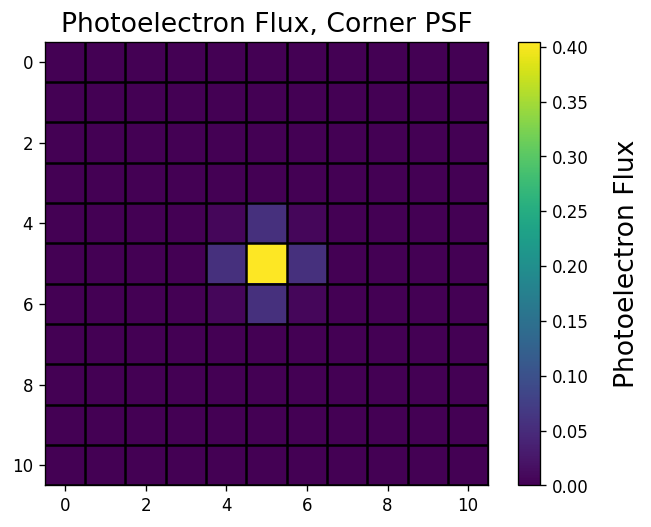

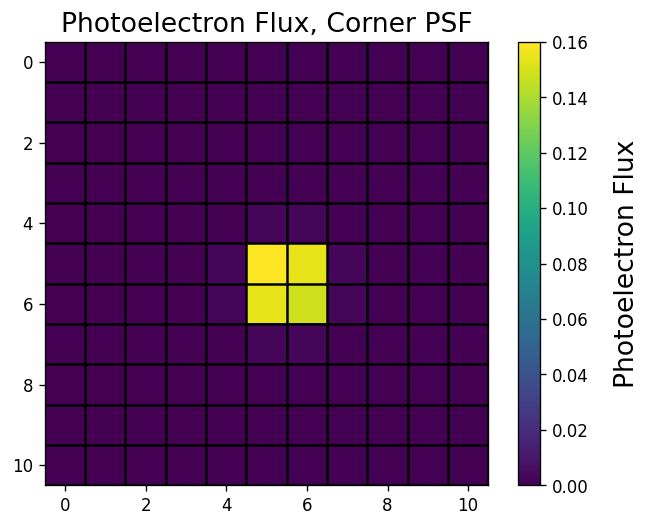

In [5]:
obs_psf_fine = true_psf * intrapix_grid
plt.imshow(obs_psf_fine)
plt.title('Photoelectron Flux, Centered PSF')
cbar = plt.colorbar(label='Photoelectron Flux')
cbar.ax.yaxis.label.set_fontsize(16)
cbar.ax.yaxis.labelpad = 15
# Add grid lines
for i in range(img_size):
    plt.axhline(i * resolution, color='black')
    plt.axvline(i * resolution, color='black')
plt.show()
shifted_obs_psf_fine = shifted_true_psf * intrapix_grid
plt.imshow(shifted_obs_psf_fine)
plt.title('Photoelectron Flux, Corner PSF')
cbar = plt.colorbar(label='Photoelectron Flux')
cbar.ax.yaxis.label.set_fontsize(16)
cbar.ax.yaxis.labelpad = 15
# Add grid lines
for i in range(img_size):
    plt.axhline(i * resolution, color='black')
    plt.axvline(i * resolution, color='black')
plt.show()
obs_psf = obs_psf_fine.reshape((img_size, resolution, img_size,
                                resolution)).sum(axis=(1, 3))
plt.imshow(obs_psf)
plt.title('Photoelectron Flux, Corner PSF')
cbar = plt.colorbar(label='Photoelectron Flux')
cbar.ax.yaxis.label.set_fontsize(16)
cbar.ax.yaxis.labelpad = 15
for i in range(img_size):
    plt.axhline(i + 0.5, color='black')
    plt.axvline(i + 0.5, color='black')
plt.show()
plt.show()
obs_psf_shifted = shifted_obs_psf_fine.reshape((img_size, resolution, img_size,
                                                resolution)).sum(axis=(1, 3))
plt.imshow(obs_psf_shifted)
plt.title('Photoelectron Flux, Corner PSF')
cbar = plt.colorbar(label='Photoelectron Flux')
cbar.ax.yaxis.label.set_fontsize(16)
cbar.ax.yaxis.labelpad = 15
for i in range(img_size):
    plt.axhline(i + 0.5, color='black')
    plt.axvline(i + 0.5, color='black')
plt.show()
plt.show()

In [6]:
true_signal = np.sum(true_psf)
obs_signal = np.sum(obs_psf)
obs_signal_shifted = np.sum(obs_psf_shifted)
true_centroid_pos_corner = [0.5 - 1 / (2 * resolution), 0.5 - 1 / (2 *resolution)]
meas_centroid_pos_corner = find_centroid_com(obs_psf_shifted)
print('True Photon Flux:', true_signal)
print('Average Sensor QE:', format(avg_qe, '.4f'))
print('Photoelectron Flux (Center):', format(obs_signal, '.4f'))
print('Photoelectron Flux (Corner):', format(obs_signal_shifted, '.4f'))
print('Center/Corner Signal Difference (ppm):', format((obs_signal - obs_signal_shifted) / obs_signal * 1e6, '.2f'))
print('True Centroid Position (Center):', np.array([0, 0]))
print('Measured Centroid Position (Center):', np.round(find_centroid_com(obs_psf),3))
print('True Centroid Position (Corner):', np.round(true_centroid_pos_corner, 5))
print('Measured Centroid Position (Corner):', np.round(meas_centroid_pos_corner, 5))


True Photon Flux: 1.0
Average Sensor QE: 0.6461
Photoelectron Flux (Center): 0.6565
Photoelectron Flux (Corner): 0.6359
Center/Corner Signal Difference (ppm): 31472.41
True Centroid Position (Center): [0 0]
Measured Centroid Position (Center): [0. 0.]
True Centroid Position (Corner): [0.4902 0.4902]
Measured Centroid Position (Corner): [0.48909 0.48909]


In [7]:
def get_iprf_effects(psf_fwhm, iprf_fwhm, psf_type='Airy', iprf_center=np.array([0,0]), 
                    shift=np.array([0.5, 0.5]), img_size=21, resolution=25):
    '''Return the signal variation and centroid difference due to the IPRF when the PSF moves.
    
    Parameters:
    ----------
    psf_fwhm : float
        FWHM of the PSF in units of pixels.
    iprf_sigma : float
        FWHM of the IPRF in units of pixels. Assumes a Gaussian IPRF.
    psf_type : str (default: 'Airy')
        Type of PSF to use. Options are 'Gaussian' and 'Airy'.
    iprf_center : array-like (default: np.array([0,0]))
        Center of the IPRF in units of pixels.
    shift : array-like (default: np.array([0.5, 0.5]))
        x and y shift of the PSF in units of pixels.
    img_size : int (default: 21)
        Size of the image in pixels. Should be large enough to contain the entire PSF.
    resolution : int (default: 25)
        Resolution of the PSF in pixels.

    Returns:
    --------
    signal_ratio : float
        Ratio of the signal measured from the shifted PSF vs the signal measured when
        the PSF is centered.
    centroid_diff : array-like
        Difference between the measured shift of the PSF centroid and the actual
        shift of the PSF centroid, in units of pixels.

    '''
    pix_size = 1.0
    iprf_sigma = iprf_fwhm * pix_size / 2.355
    # round shift to units of 1 / resolution
    shift_x = np.rint(shift[0] * resolution).astype(int)
    shift_y = np.rint(shift[1] * resolution).astype(int)
    shift_round_pix = np.array([shift_x, shift_y]) / resolution
    if psf_type == 'Gaussian':
        psf_sigma = psf_fwhm * pix_size / 2.355
        true_psf_center = psfs.gaussian_psf(img_size, resolution, pix_size, [0,0], [[psf_sigma ** 2, 0],[0, psf_sigma ** 2]])
    elif psf_type == 'Airy':
        lam_fnum_angstroms = psf_fwhm * pix_size / 1.029 * 1e4
        true_psf_center = psfs.airy_disk(img_size, resolution, pix_size, [0,0], lam=lam_fnum_angstroms, fnum=1.0)
    # truncate the PSF so that we don't misinterpret wings falling off the edge of the image as
    # a difference due to the IPRF
    true_psf_center[:resolution+1, :] = 0
    true_psf_center[-resolution-1:, :] = 0
    true_psf_center[:, :resolution+1] = 0
    true_psf_center[:, -resolution-1:] = 0
    true_psf_shifted = shift_values(true_psf_center, shift_x, shift_y)
    cutoff_frac = true_psf_shifted.sum() / true_psf_center.sum()
    # Confirm that any difference in signal is not just because part of the PSF is cut off
    # print(true_psf_shifted.sum() / true_psf_center.sum())
    intrapix_single = psfs.gaussian_psf(1, resolution, pix_size, iprf_center,
                                        [[iprf_sigma ** 2, 0],[0, iprf_sigma ** 2]])
    # Normalize the intrapixel response to have a maximum of 1
    intrapix_single = intrapix_single / np.max(intrapix_single)
    intrapix_grid = np.tile(intrapix_single, (img_size, img_size))
    obs_psf_center = true_psf_center * intrapix_grid
    obs_psf_shifted = true_psf_shifted * intrapix_grid
    obs_psf_center = obs_psf_center.reshape((img_size, resolution, img_size, resolution)).sum(axis=(1, 3))
    obs_psf_shifted = obs_psf_shifted.reshape((img_size, resolution, img_size, resolution)).sum(axis=(1, 3))
    signal_ratio = np.sum(obs_psf_shifted) / np.sum(obs_psf_center) / cutoff_frac
    meas_centroid_center = find_centroid_com(obs_psf_center)
    meas_centroid_corner = find_centroid_com(obs_psf_shifted)
    centroid_diff = meas_centroid_corner - meas_centroid_center - shift_round_pix
    return signal_ratio, centroid_diff

In [8]:
get_iprf_effects(psf_fwhm=1.0, iprf_fwhm=1.0, psf_type='Airy', iprf_center=[0,0], shift=[0.5, 0.5], img_size=35, resolution=51)

(0.9936141537854448, array([0.00094482, 0.00094482]))

In [9]:
psf_fwhm_array = np.linspace(0.5, 2.5, 9)
iprf_fwhm_array = np.linspace(0.5, 2.5, 9)
psf_fwhm_spacing = psf_fwhm_array[1] - psf_fwhm_array[0]
iprf_fwhm_spacing = iprf_fwhm_array[1] - iprf_fwhm_array[0]
signal_ratios = np.zeros((len(psf_fwhm_array), len(iprf_fwhm_array)))
centroid_diffs = np.zeros((len(psf_fwhm_array), len(iprf_fwhm_array), 2))
for i, psf_fwhm in enumerate(psf_fwhm_array):
    for j, iprf_fwhm in enumerate(iprf_fwhm_array):
        signal_ratios[i, j], centroid_diffs[i, j] = get_iprf_effects(psf_fwhm, iprf_fwhm, psf_type='Gaussian', iprf_center=[0,0], shift=[0.25, 0.25], img_size=25, resolution=25)


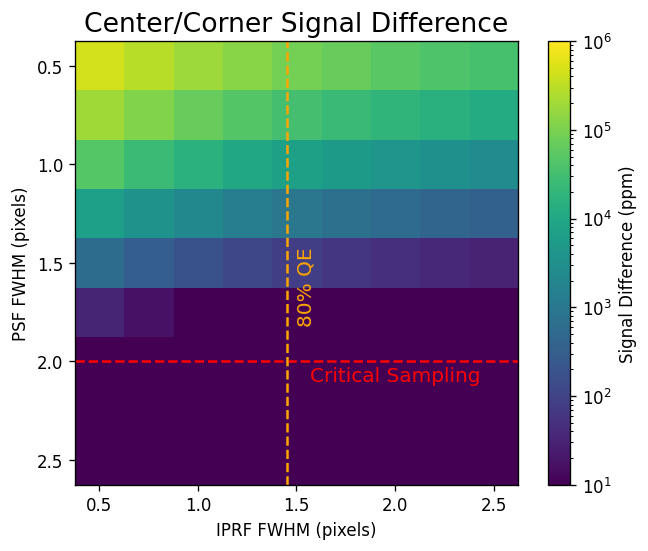

In [10]:
from matplotlib.colors import LogNorm
%matplotlib inline
signal_diffs_ppm = abs((1 - signal_ratios) * 1e6)
imshow_extent = (iprf_fwhm_array[0] - iprf_fwhm_spacing / 2, iprf_fwhm_array[-1] + iprf_fwhm_spacing / 2,
                 psf_fwhm_array[-1] + psf_fwhm_spacing / 2, psf_fwhm_array[0] - psf_fwhm_spacing / 2)
plt.imshow(signal_diffs_ppm, extent=imshow_extent, norm=LogNorm(vmin=1e1, vmax=1e6))
plt.xticks(iprf_fwhm_array[::2])
plt.yticks(psf_fwhm_array[::2])
plt.colorbar(label='Signal Difference (ppm)')
plt.xlabel('IPRF FWHM (pixels)')
plt.ylabel('PSF FWHM (pixels)')
plt.title('Center/Corner Signal Difference')
plt.axhline(2, color='red', linestyle='--')
plt.text(2.0, 2.1, 'Critical Sampling', color='red', fontsize=12, ha='center')
plt.axvline(1.45, color='orange', linestyle='--')
plt.text(1.55, 1.8, '80% QE', color='orange', fontsize=12, ha='center', rotation=90)
plt.show()

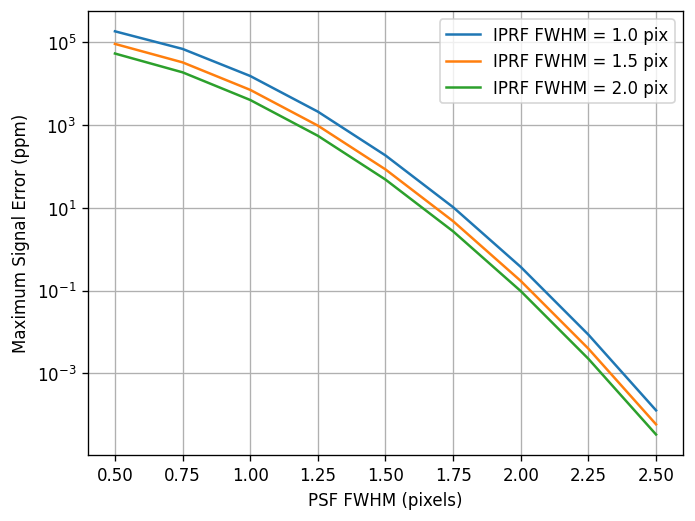

In [11]:
plt.plot(psf_fwhm_array, signal_diffs_ppm[:, 2], label='IPRF FWHM = 1.0 pix')
plt.plot(psf_fwhm_array, signal_diffs_ppm[:, 4], label='IPRF FWHM = 1.5 pix')
plt.plot(psf_fwhm_array, signal_diffs_ppm[:, 6], label='IPRF FWHM = 2.0 pix')
plt.xlabel('PSF FWHM (pixels)')
plt.ylabel('Maximum Signal Error (ppm)')
plt.legend()
# plt.title('Signal Difference vs PSF FWHM (IPRF FWHM = 1.5 pix)')
plt.yscale('log')
# Only put horizontal grid lines
plt.grid()
plt.show()

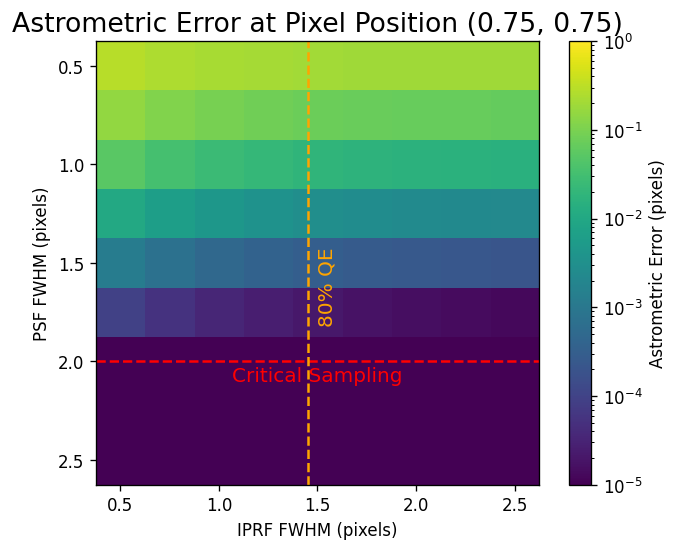

In [12]:
from matplotlib.colors import LogNorm
centroid_diffs_r = np.linalg.norm(centroid_diffs, axis=2)
imshow_extent = (iprf_fwhm_array[0] - iprf_fwhm_spacing / 2, iprf_fwhm_array[-1] + iprf_fwhm_spacing / 2,
                 psf_fwhm_array[-1] + psf_fwhm_spacing / 2, psf_fwhm_array[0] - psf_fwhm_spacing / 2)
plt.imshow(centroid_diffs_r, extent=imshow_extent, norm=LogNorm(vmin=1e-5, vmax=1e0))
plt.xticks(iprf_fwhm_array[::2])
plt.yticks(psf_fwhm_array[::2])
plt.colorbar(label='Astrometric Error (pixels)')
plt.xlabel('IPRF FWHM (pixels)')
plt.ylabel('PSF FWHM (pixels)')
plt.axhline(2, color='red', linestyle='--')
plt.text(1.5, 2.1, 'Critical Sampling', color='red', fontsize=12, ha='center')
plt.axvline(1.45, color='orange', linestyle='--')
plt.text(1.55, 1.8, '80% QE', color='orange', fontsize=12, ha='center', rotation=90)
plt.title('Astrometric Error at Pixel Position (0.75, 0.75)')
plt.show()

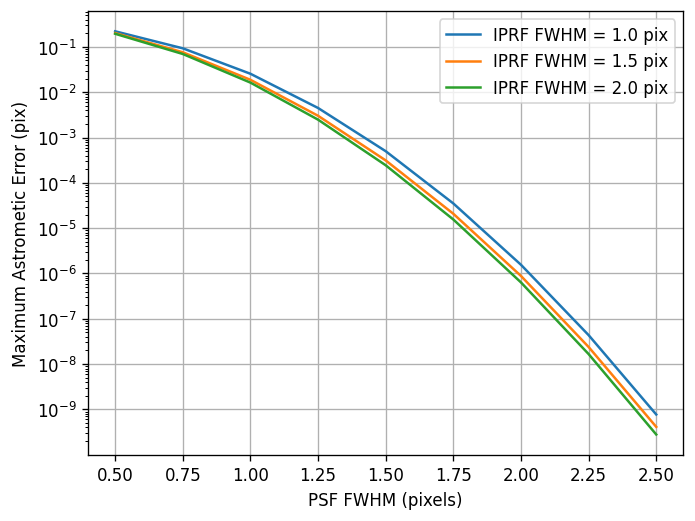

In [13]:
plt.plot(psf_fwhm_array, centroid_diffs_r[:, 2], label='IPRF FWHM = 1.0 pix')
plt.plot(psf_fwhm_array, centroid_diffs_r[:, 4], label='IPRF FWHM = 1.5 pix')
plt.plot(psf_fwhm_array, centroid_diffs_r[:, 6], label='IPRF FWHM = 2.0 pix')
plt.xlabel('PSF FWHM (pixels)')
plt.ylabel('Maximum Astrometic Error (pix)')
plt.legend()
plt.yscale('log')
# Only put horizontal grid lines
plt.grid()
plt.show()